# Introduction
<hr style = "border:2px solid black" ></hr>


**What?**  Mental Fatigue Score Prediction



# Why CatBoost?
<hr style = "border:2px solid black" ></hr>


- Highly accurate model building with great GPU or CPU training speed.
- Offers remarkable result with default parameters.
- It Works well with categorical variables (**as the name itself suggests**) and no need to preprocess them (like one-hot encoding).
- Cool Visualizations like Feature importance, training process visualization.
- Simple to use with Python package.



# Installation of packages
<hr style = "border:2px solid black" ></hr>

In [ ]:
!pip install catboost
!pip install ipywidgets

In [2]:
# Still it did not work for me!
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Import modules
<hr style = "border:2px solid black" ></hr>

In [3]:
import catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import math
from catboost import Pool
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Load dataset
<hr style = "border:2px solid black" ></hr>


- `Employee ID`: The unique ID allocated for each employee (example: fffe390032003000)
- `Date of Joining`: The date-time when the employee has joined the organization (example: 2008-12-30)
- `Gender`: The gender of the employee (Male/Female)
- `Company Type`: The type of company where the employee is working (Service/Product)
- `WFH Setup Available`: Is the work from home facility available for the employee (Yes/No)
- `Designation`: The designation of the employee of work in the organization.
    - In the range of [0.0, 5.0] bigger is higher designation.
- `Resource Allocation`: The amount of resource allocated to the employee to work, ie. number of working hours.
    -In the range of [1.0, 10.0] (higher means more resource) 
- `Mental Fatigue Score`: The level of fatigue mentally the employee is facing.
    - In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
- `Burn Rate`: The value we need to predict for each employee telling the rate of Bur out while working.
    -In the range of [0.0, 1.0] where the higher the value is more is the burn out.




In [4]:
!ls ../DATASETS/BurnDownRate

test.csv  train.csv


In [5]:
df = pd.read_csv("../DATASETS/BurnDownRate/train.csv", sep = ",")
df.head(5)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [6]:
print("shape of dataframe is : ", df.shape)

shape of dataframe is :  (22750, 9)


# Data cleaning
<hr style = "border:2px solid black" ></hr>

In [7]:
# Checking null value percentage column wise
df.isnull().mean()*100

Employee ID             0.000000
Date of Joining         0.000000
Gender                  0.000000
Company Type            0.000000
WFH Setup Available     0.000000
Designation             0.000000
Resource Allocation     6.070330
Mental Fatigue Score    9.305495
Burn Rate               4.940659
dtype: float64


- It is good practice to do some research to explain the null value patterns. 
- Then we can use mean, median, or mode to impute null values, or construct a new category called “missing,” or simply delete them if the percentage is very small.
- Here, we'll apply a lazy approach and we'll simply get rid of any row that has at list one null value.



In [8]:
df = df.dropna(how = 'any', axis = 0) 

In [9]:
df.shape

(18590, 9)

In [10]:
# Double checking if we got rid of the null values
df.isnull().mean()*100

Employee ID             0.0
Date of Joining         0.0
Gender                  0.0
Company Type            0.0
WFH Setup Available     0.0
Designation             0.0
Resource Allocation     0.0
Mental Fatigue Score    0.0
Burn Rate               0.0
dtype: float64

# Feature engineering
<hr style = "border:2px solid black" ></hr>


- We will not create dummy variables for categorical columns since we’re using CatBoost, which doesn’t need categorical variables to be preprocessed like one hot encoding.
- Create a new column called `days_count` that counts how many days have passed since the date of entering.
- Drop the `employee ID` and `Date of Joining` columns because employee ID is just a special identifier, and we’ll use a newly generated column instead of Date of Joining



In [11]:
# Function to find out total days
def create_days_count(data):
    return (current_date - data["Date of Joining"])

In [12]:
# Converting date of joining column to pandas datetime format
df["Date of Joining"] = pd.to_datetime(df["Date of Joining"])

In [13]:
# Get todays date time
current_date = pd.to_datetime('today')  
# Creating new column days_count
df["days_count"] = df.apply(create_days_count, axis=1).dt.days

In [14]:
# We will drop employeeid and date of joining columns.
df.drop(["Employee ID","Date of Joining"],axis=1,inplace=True)

In [15]:
df.head(5)

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,days_count
0,Female,Service,No,2.0,3.0,3.8,0.16,4772
1,Male,Service,Yes,1.0,2.0,5.0,0.36,4711
3,Male,Service,Yes,1.0,1.0,2.6,0.20,4738
4,Female,Service,No,3.0,7.0,6.9,0.52,4840
5,Male,Product,Yes,2.0,4.0,3.6,0.29,4715


# Train-test split
<hr style = "border:2px solid black" ></hr>

In [16]:
y = df.pop("Mental Fatigue Score")
X = df

In [17]:
X

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Burn Rate,days_count
0,Female,Service,No,2.0,3.0,0.16,4772
1,Male,Service,Yes,1.0,2.0,0.36,4711
3,Male,Service,Yes,1.0,1.0,0.20,4738
4,Female,Service,No,3.0,7.0,0.52,4840
5,Male,Product,Yes,2.0,4.0,0.29,4715
...,...,...,...,...,...,...,...
22743,Female,Product,Yes,1.0,3.0,0.48,4696
22744,Male,Product,No,3.0,7.0,0.54,4898
22746,Female,Product,Yes,3.0,6.0,0.59,5027
22748,Female,Service,No,2.0,5.0,0.52,5036


In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42)

print("train data size:",X_train.shape)
print("test data size:",X_test.shape)

train data size: (14872, 7)
test data size: (3718, 7)


In [19]:
# List of categorical columns
categoricalcolumns = X.select_dtypes(include=["object"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
# Get location of categorical columns
cat_features = [X.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)

Names of categorical columns :  ['Gender', 'Company Type', 'WFH Setup Available']
Location of categorical columns :  [0, 1, 2]


# Pool object
<hr style = "border:2px solid black" ></hr>


- The Pool function in CatBoost combines independent and dependent variables (X and y), as well as categorical features.
- We give information of categorical fetures to parameter `cat_fetaures`.



In [20]:
# Creating pool object for train dataset. 
train_data = Pool(data = X_train,
                  label = y_train,
                  cat_features = cat_features
                 )
# Creating pool object for test dataset
test_data = Pool(data = X_test,
                  label = y_test,
                  cat_features=cat_features
                 )

In [21]:
X.columns

Index(['Gender', 'Company Type', 'WFH Setup Available', 'Designation',
       'Resource Allocation', 'Burn Rate', 'days_count'],
      dtype='object')

In [22]:
train_data.get_feature_names()

['Gender',
 'Company Type',
 'WFH Setup Available',
 'Designation',
 'Resource Allocation',
 'Burn Rate',
 'days_count']

# Model training
<hr style = "border:2px solid black" ></hr>

In [23]:
# Build model
cat_model = CatBoostRegressor(loss_function ="RMSE")
# Fit model 
results = cat_model.fit(train_data, eval_set = (test_data), plot = False)

Learning rate set to 0.076748
0:	learn: 1.7986081	test: 1.7836278	best: 1.7836278 (0)	total: 58ms	remaining: 57.9s
1:	learn: 1.6875570	test: 1.6729490	best: 1.6729490 (1)	total: 61ms	remaining: 30.5s
2:	learn: 1.5856169	test: 1.5712655	best: 1.5712655 (2)	total: 64ms	remaining: 21.3s
3:	learn: 1.4914677	test: 1.4780539	best: 1.4780539 (3)	total: 66.8ms	remaining: 16.6s
4:	learn: 1.4020768	test: 1.3905564	best: 1.3905564 (4)	total: 69.5ms	remaining: 13.8s
5:	learn: 1.3215142	test: 1.3111552	best: 1.3111552 (5)	total: 72.2ms	remaining: 12s
6:	learn: 1.2454066	test: 1.2368499	best: 1.2368499 (6)	total: 74.8ms	remaining: 10.6s
7:	learn: 1.1778645	test: 1.1697248	best: 1.1697248 (7)	total: 77.7ms	remaining: 9.63s
8:	learn: 1.1174659	test: 1.1098427	best: 1.1098427 (8)	total: 80.3ms	remaining: 8.84s
9:	learn: 1.0625180	test: 1.0552430	best: 1.0552430 (9)	total: 82.9ms	remaining: 8.21s
10:	learn: 1.0103425	test: 1.0035879	best: 1.0035879 (10)	total: 85.6ms	remaining: 7.7s
11:	learn: 0.9636903

110:	learn: 0.5745131	test: 0.5796164	best: 0.5796164 (110)	total: 372ms	remaining: 2.98s
111:	learn: 0.5743772	test: 0.5796551	best: 0.5796164 (110)	total: 375ms	remaining: 2.97s
112:	learn: 0.5742735	test: 0.5796786	best: 0.5796164 (110)	total: 378ms	remaining: 2.97s
113:	learn: 0.5741392	test: 0.5796441	best: 0.5796164 (110)	total: 381ms	remaining: 2.96s
114:	learn: 0.5740132	test: 0.5796559	best: 0.5796164 (110)	total: 384ms	remaining: 2.96s
115:	learn: 0.5739473	test: 0.5796901	best: 0.5796164 (110)	total: 387ms	remaining: 2.95s
116:	learn: 0.5738224	test: 0.5796089	best: 0.5796089 (116)	total: 390ms	remaining: 2.94s
117:	learn: 0.5737269	test: 0.5795627	best: 0.5795627 (117)	total: 393ms	remaining: 2.94s
118:	learn: 0.5736661	test: 0.5795660	best: 0.5795627 (117)	total: 396ms	remaining: 2.93s
119:	learn: 0.5735320	test: 0.5795680	best: 0.5795627 (117)	total: 400ms	remaining: 2.93s
120:	learn: 0.5734606	test: 0.5795557	best: 0.5795557 (120)	total: 403ms	remaining: 2.93s
121:	learn

220:	learn: 0.5654968	test: 0.5795275	best: 0.5793169 (199)	total: 674ms	remaining: 2.38s
221:	learn: 0.5654124	test: 0.5795648	best: 0.5793169 (199)	total: 677ms	remaining: 2.37s
222:	learn: 0.5653815	test: 0.5795695	best: 0.5793169 (199)	total: 679ms	remaining: 2.37s
223:	learn: 0.5652829	test: 0.5795837	best: 0.5793169 (199)	total: 683ms	remaining: 2.37s
224:	learn: 0.5652111	test: 0.5795863	best: 0.5793169 (199)	total: 686ms	remaining: 2.36s
225:	learn: 0.5651473	test: 0.5796059	best: 0.5793169 (199)	total: 689ms	remaining: 2.36s
226:	learn: 0.5651038	test: 0.5795843	best: 0.5793169 (199)	total: 692ms	remaining: 2.35s
227:	learn: 0.5650436	test: 0.5796174	best: 0.5793169 (199)	total: 695ms	remaining: 2.35s
228:	learn: 0.5649593	test: 0.5796622	best: 0.5793169 (199)	total: 698ms	remaining: 2.35s
229:	learn: 0.5648508	test: 0.5796887	best: 0.5793169 (199)	total: 701ms	remaining: 2.35s
230:	learn: 0.5647830	test: 0.5797085	best: 0.5793169 (199)	total: 704ms	remaining: 2.34s
231:	learn

316:	learn: 0.5589950	test: 0.5802670	best: 0.5793169 (199)	total: 933ms	remaining: 2.01s
317:	learn: 0.5589535	test: 0.5802445	best: 0.5793169 (199)	total: 936ms	remaining: 2.01s
318:	learn: 0.5588545	test: 0.5802760	best: 0.5793169 (199)	total: 939ms	remaining: 2s
319:	learn: 0.5587845	test: 0.5803004	best: 0.5793169 (199)	total: 941ms	remaining: 2s
320:	learn: 0.5587441	test: 0.5803278	best: 0.5793169 (199)	total: 944ms	remaining: 2s
321:	learn: 0.5586955	test: 0.5803545	best: 0.5793169 (199)	total: 947ms	remaining: 1.99s
322:	learn: 0.5586312	test: 0.5803573	best: 0.5793169 (199)	total: 950ms	remaining: 1.99s
323:	learn: 0.5585592	test: 0.5803437	best: 0.5793169 (199)	total: 953ms	remaining: 1.99s
324:	learn: 0.5584742	test: 0.5804125	best: 0.5793169 (199)	total: 956ms	remaining: 1.98s
325:	learn: 0.5584202	test: 0.5804097	best: 0.5793169 (199)	total: 958ms	remaining: 1.98s
326:	learn: 0.5583833	test: 0.5803952	best: 0.5793169 (199)	total: 962ms	remaining: 1.98s
327:	learn: 0.55827

422:	learn: 0.5524772	test: 0.5812764	best: 0.5793169 (199)	total: 1.23s	remaining: 1.68s
423:	learn: 0.5524027	test: 0.5812940	best: 0.5793169 (199)	total: 1.24s	remaining: 1.68s
424:	learn: 0.5523532	test: 0.5813157	best: 0.5793169 (199)	total: 1.24s	remaining: 1.68s
425:	learn: 0.5523119	test: 0.5813291	best: 0.5793169 (199)	total: 1.25s	remaining: 1.68s
426:	learn: 0.5522619	test: 0.5813129	best: 0.5793169 (199)	total: 1.25s	remaining: 1.68s
427:	learn: 0.5522211	test: 0.5813449	best: 0.5793169 (199)	total: 1.25s	remaining: 1.68s
428:	learn: 0.5521667	test: 0.5813589	best: 0.5793169 (199)	total: 1.26s	remaining: 1.68s
429:	learn: 0.5521393	test: 0.5813613	best: 0.5793169 (199)	total: 1.26s	remaining: 1.67s
430:	learn: 0.5520991	test: 0.5813554	best: 0.5793169 (199)	total: 1.26s	remaining: 1.67s
431:	learn: 0.5520629	test: 0.5813911	best: 0.5793169 (199)	total: 1.27s	remaining: 1.67s
432:	learn: 0.5519862	test: 0.5813880	best: 0.5793169 (199)	total: 1.27s	remaining: 1.66s
433:	learn

557:	learn: 0.5456012	test: 0.5822545	best: 0.5793169 (199)	total: 1.61s	remaining: 1.27s
558:	learn: 0.5455719	test: 0.5822588	best: 0.5793169 (199)	total: 1.61s	remaining: 1.27s
559:	learn: 0.5455224	test: 0.5822622	best: 0.5793169 (199)	total: 1.61s	remaining: 1.27s
560:	learn: 0.5454834	test: 0.5822806	best: 0.5793169 (199)	total: 1.62s	remaining: 1.26s
561:	learn: 0.5454463	test: 0.5823040	best: 0.5793169 (199)	total: 1.62s	remaining: 1.26s
562:	learn: 0.5454184	test: 0.5823186	best: 0.5793169 (199)	total: 1.62s	remaining: 1.26s
563:	learn: 0.5453814	test: 0.5823420	best: 0.5793169 (199)	total: 1.62s	remaining: 1.25s
564:	learn: 0.5453281	test: 0.5823639	best: 0.5793169 (199)	total: 1.63s	remaining: 1.25s
565:	learn: 0.5452428	test: 0.5823862	best: 0.5793169 (199)	total: 1.63s	remaining: 1.25s
566:	learn: 0.5451868	test: 0.5824142	best: 0.5793169 (199)	total: 1.63s	remaining: 1.25s
567:	learn: 0.5451580	test: 0.5824294	best: 0.5793169 (199)	total: 1.64s	remaining: 1.24s
568:	learn

651:	learn: 0.5411751	test: 0.5833128	best: 0.5793169 (199)	total: 1.86s	remaining: 995ms
652:	learn: 0.5411613	test: 0.5833203	best: 0.5793169 (199)	total: 1.87s	remaining: 992ms
653:	learn: 0.5411236	test: 0.5833410	best: 0.5793169 (199)	total: 1.87s	remaining: 990ms
654:	learn: 0.5410903	test: 0.5833376	best: 0.5793169 (199)	total: 1.87s	remaining: 987ms
655:	learn: 0.5410119	test: 0.5833137	best: 0.5793169 (199)	total: 1.88s	remaining: 985ms
656:	learn: 0.5409842	test: 0.5833331	best: 0.5793169 (199)	total: 1.88s	remaining: 982ms
657:	learn: 0.5409328	test: 0.5833438	best: 0.5793169 (199)	total: 1.89s	remaining: 980ms
658:	learn: 0.5409039	test: 0.5833493	best: 0.5793169 (199)	total: 1.89s	remaining: 977ms
659:	learn: 0.5408615	test: 0.5834049	best: 0.5793169 (199)	total: 1.89s	remaining: 974ms
660:	learn: 0.5408321	test: 0.5834180	best: 0.5793169 (199)	total: 1.89s	remaining: 971ms
661:	learn: 0.5408147	test: 0.5834337	best: 0.5793169 (199)	total: 1.9s	remaining: 968ms
662:	learn:

751:	learn: 0.5367497	test: 0.5841783	best: 0.5793169 (199)	total: 2.17s	remaining: 714ms
752:	learn: 0.5367065	test: 0.5841662	best: 0.5793169 (199)	total: 2.17s	remaining: 712ms
753:	learn: 0.5366889	test: 0.5841633	best: 0.5793169 (199)	total: 2.17s	remaining: 709ms
754:	learn: 0.5366446	test: 0.5841693	best: 0.5793169 (199)	total: 2.18s	remaining: 707ms
755:	learn: 0.5366053	test: 0.5841591	best: 0.5793169 (199)	total: 2.18s	remaining: 704ms
756:	learn: 0.5365660	test: 0.5841880	best: 0.5793169 (199)	total: 2.19s	remaining: 702ms
757:	learn: 0.5365440	test: 0.5841732	best: 0.5793169 (199)	total: 2.19s	remaining: 699ms
758:	learn: 0.5364758	test: 0.5841686	best: 0.5793169 (199)	total: 2.19s	remaining: 697ms
759:	learn: 0.5364311	test: 0.5841482	best: 0.5793169 (199)	total: 2.2s	remaining: 694ms
760:	learn: 0.5363657	test: 0.5841354	best: 0.5793169 (199)	total: 2.2s	remaining: 691ms
761:	learn: 0.5363193	test: 0.5841212	best: 0.5793169 (199)	total: 2.2s	remaining: 688ms
762:	learn: 0

848:	learn: 0.5328119	test: 0.5844639	best: 0.5793169 (199)	total: 2.42s	remaining: 431ms
849:	learn: 0.5327674	test: 0.5844651	best: 0.5793169 (199)	total: 2.43s	remaining: 428ms
850:	learn: 0.5327281	test: 0.5844789	best: 0.5793169 (199)	total: 2.43s	remaining: 425ms
851:	learn: 0.5327006	test: 0.5844923	best: 0.5793169 (199)	total: 2.43s	remaining: 423ms
852:	learn: 0.5326535	test: 0.5845008	best: 0.5793169 (199)	total: 2.44s	remaining: 420ms
853:	learn: 0.5325773	test: 0.5845505	best: 0.5793169 (199)	total: 2.44s	remaining: 417ms
854:	learn: 0.5325439	test: 0.5845675	best: 0.5793169 (199)	total: 2.44s	remaining: 414ms
855:	learn: 0.5324908	test: 0.5845774	best: 0.5793169 (199)	total: 2.44s	remaining: 411ms
856:	learn: 0.5323863	test: 0.5845790	best: 0.5793169 (199)	total: 2.45s	remaining: 408ms
857:	learn: 0.5323564	test: 0.5845908	best: 0.5793169 (199)	total: 2.45s	remaining: 405ms
858:	learn: 0.5323246	test: 0.5846010	best: 0.5793169 (199)	total: 2.45s	remaining: 403ms
859:	learn

962:	learn: 0.5281104	test: 0.5854592	best: 0.5793169 (199)	total: 2.72s	remaining: 105ms
963:	learn: 0.5280810	test: 0.5854548	best: 0.5793169 (199)	total: 2.73s	remaining: 102ms
964:	learn: 0.5280453	test: 0.5854548	best: 0.5793169 (199)	total: 2.73s	remaining: 99ms
965:	learn: 0.5280130	test: 0.5854533	best: 0.5793169 (199)	total: 2.73s	remaining: 96.2ms
966:	learn: 0.5279770	test: 0.5854263	best: 0.5793169 (199)	total: 2.74s	remaining: 93.4ms
967:	learn: 0.5279481	test: 0.5854640	best: 0.5793169 (199)	total: 2.74s	remaining: 90.6ms
968:	learn: 0.5279231	test: 0.5854647	best: 0.5793169 (199)	total: 2.74s	remaining: 87.7ms
969:	learn: 0.5278960	test: 0.5854672	best: 0.5793169 (199)	total: 2.74s	remaining: 84.9ms
970:	learn: 0.5278691	test: 0.5854922	best: 0.5793169 (199)	total: 2.75s	remaining: 82.1ms
971:	learn: 0.5278559	test: 0.5854892	best: 0.5793169 (199)	total: 2.75s	remaining: 79.2ms
972:	learn: 0.5278185	test: 0.5855165	best: 0.5793169 (199)	total: 2.75s	remaining: 76.4ms
973

In [24]:
dir(results)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_calc_leaf_indexes',
 '_base_drop_unused_features',
 '_base_eval_metrics',
 '_base_predict',
 '_base_shrink',
 '_base_virtual_ensembles_predict',
 '_calc_fstr',
 '_calc_leaf_indexes',
 '_calc_ostr',
 '_check_is_compatible_loss',
 '_convert_to_asymmetric_representation',
 '_deserialize_model',
 '_estimator_type',
 '_eval_metrics',
 '_fit',
 '_get_borders',
 '_get_cat_feature_indices',
 '_get_default_prediction_type',
 '_get_embedding_feature_indices',
 '_get_float_feature_indices',
 '_get_nan_treatments',
 '_get_params',
 '_get_tags',
 '_get_text_feature

In [25]:
dir(cat_model)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_calc_leaf_indexes',
 '_base_drop_unused_features',
 '_base_eval_metrics',
 '_base_predict',
 '_base_shrink',
 '_base_virtual_ensembles_predict',
 '_calc_fstr',
 '_calc_leaf_indexes',
 '_calc_ostr',
 '_check_is_compatible_loss',
 '_convert_to_asymmetric_representation',
 '_deserialize_model',
 '_estimator_type',
 '_eval_metrics',
 '_fit',
 '_get_borders',
 '_get_cat_feature_indices',
 '_get_default_prediction_type',
 '_get_embedding_feature_indices',
 '_get_float_feature_indices',
 '_get_nan_treatments',
 '_get_params',
 '_get_tags',
 '_get_text_feature

# Plotting learning curves
<hr style = "border:2px solid black" ></hr>

In [26]:
cat_model.evals_result_.keys()

dict_keys(['learn', 'validation'])

In [27]:
cat_model.evals_result_["learn"]["RMSE"]

[1.7986081064137205,
 1.687557026185839,
 1.585616939234313,
 1.4914677424036664,
 1.4020767998850983,
 1.3215142436154124,
 1.2454066244311113,
 1.1778645222694026,
 1.1174659069515598,
 1.062517982660554,
 1.0103425076141945,
 0.9636903397690731,
 0.9213336449123575,
 0.8837079395857315,
 0.85046915698054,
 0.8189796679420278,
 0.7906030951599131,
 0.7656457152467947,
 0.7431142529660089,
 0.7237363298399223,
 0.7074361090888818,
 0.6915094600164248,
 0.6782227639843329,
 0.6664736316512522,
 0.6552645711310114,
 0.645494521143628,
 0.6368318552965111,
 0.6297742492014254,
 0.6235718934439164,
 0.6178895483791217,
 0.6130000794616449,
 0.6087036521467725,
 0.6049714710891738,
 0.6021782778358568,
 0.5995657793420158,
 0.5971482363934892,
 0.5948671297005576,
 0.592940418686282,
 0.5911972861924079,
 0.5898319172849229,
 0.5884649647363253,
 0.5873798469109431,
 0.5864370359999532,
 0.5856270268710342,
 0.5848860728155084,
 0.5842066404204677,
 0.5836046970247691,
 0.5830581231027057,

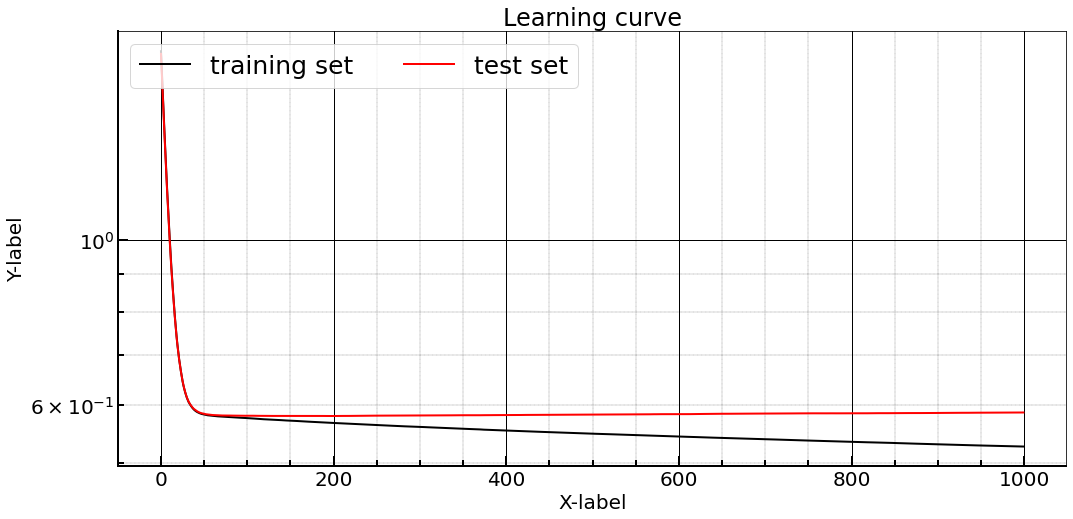

In [28]:
rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

fig = plt.figure() 
plt.title("Learning curve")
ax = fig.add_subplot(111) 

xx = range(len(cat_model.evals_result_["learn"]["RMSE"]))
plt.plot(xx, cat_model.evals_result_["learn"]["RMSE"], "-k", lw = 2, label = "training set")
plt.plot(xx, cat_model.evals_result_["validation"]["RMSE"], "-r", lw = 2, label = "test set")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("X-label")
ax.set_ylabel("Y-label")


plt.yscale('log')
plt.legend(loc = 'upper left', ncol = 4, fontsize = 25)

# Features importance
<hr style = "border:2px solid black" ></hr>

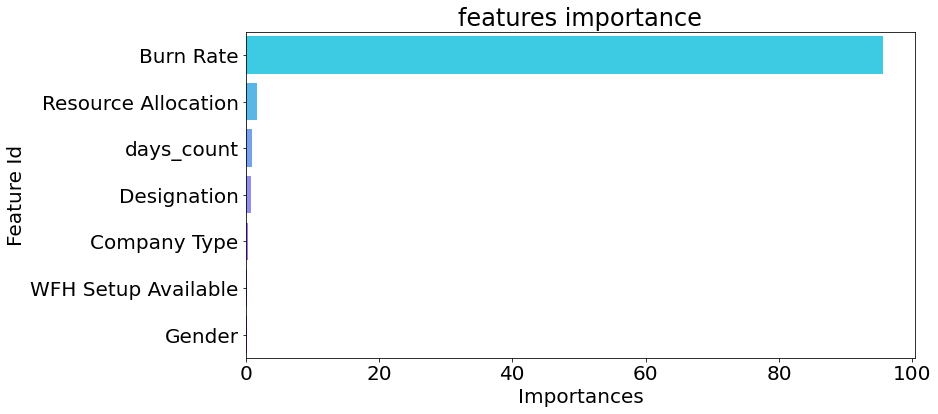

In [29]:
# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
# Plotting
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');

# Performance
<hr style = "border:2px solid black" ></hr>


- **Adjusted R-squared**: every additional independent variable added to a model always increases the R-squared value — therefore, a model with several independent variables may seem to be a better fit even if it isn’t. 
- This is where adjusted R² comes in. The adjusted R² compensates for each additional independent variable and only increases if each given variable improves the model above what is possible by probability.
- The predicted R-squared, unlike the adjusted R-squared, is used to indicate how well a regression model predicts responses for new observations.



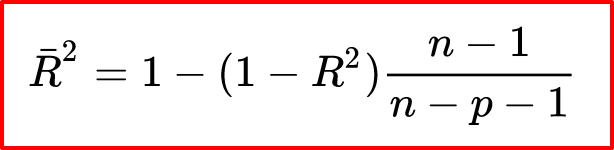

In [30]:
y_predict= cat_model.predict(X_test)
# RMSE
Rmse_test = math.sqrt(mean_squared_error(y_test,y_predict))

# R2 Score
r2_test = r2_score(y_test,y_predict)

# Adjusted R2 Score
n = X_train.shape[0] # total no of datapoints
p = X_train.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

In [31]:
print("Evaluation on test data")
print("RMSE: {:.4f}".format(Rmse_test))
print("R2: {:.4f}".format(r2_test))
print("Adjusted R2: {:.4f}".format(adj_r2_test))

Evaluation on test data
RMSE: 0.5793
R2: 0.9078
Adjusted R2: 0.9078


In [32]:
# Remove temp file saved locally
!rm -rf catboost_info

In [1]:
!ls

GitHub_MD_rendering                   README.md
Mental Fatigue Score Prediction.ipynb


# References
<hr style = "border:2px solid black" ></hr>


- https://www.analyticsvidhya.com/blog/2021/04/how-to-use-catboost-for-mental-fatigue-score-prediction/
- [CatBoost](https://catboost.ai/#benchmark)
- [Dataset download](https://www.kaggle.com/blurredmachine/are-your-employees-burning-out?select=train.csv)
- [Adjusted R2 ref #1](https://towardsdatascience.com/understanding-multiple-regression-249b16bde83e)
- [Adjusted R2 ref #2](https://www.investopedia.com/ask/answers/012615/whats-difference-between-rsquared-and-adjusted-rsquared.asp)
- [Adjusted R2 formula](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2)
   
